In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

def open_sheet(sheet_name):
    df_open = pd.read_excel(sheet_name)
    return remove_df_unnamed(df_open)

def remove_df_unnamed(df_rem):
    for col in df_rem.columns:
        if "Unnamed" in col or 'index' in col:
            del df_rem[col]
    return df_rem

def alterar_coluna_dataHora(dataframe):
    dataframe = dataframe.astype({'Hora':'string'})
    print("Alterou Type")
    for x in range(len(dataframe)):
        value=dataframe.loc[x,"Datahora"]
        split=value.split(":")
        dataframe.loc[x,'Datahora'] = split[0]
        dataframe.loc[x,"Mês"]=split[1].lstrip('0')
        dataframe.loc[x,'Hora'] = value.split(" ")[1]
    return dataframe

def alterar_coluna_dia(dataframe):
    dataframe = dataframe.astype({'Dia':'string'})
    print("Antes do for")
    for i in range(dataframe.shape[0]):
        val = dataframe.loc[i,'Dia']
        i_dia = val.split(' ')[0].split('-')[2]
        dataframe.loc[i,'Dia'] = i_dia
    print("Depois do for")
    return dataframe

def get_1000_de_cada_file(df_files):
    all_df=[]
    for df_year in df_files:
        print("Novo ano")
        total_lines = df_year.shape[0]
        all_df_year = []
        for j in range(1,13):
            df_month = df_year[df_year['Mês']==str(j)]
            perc_total_amostra = df_month.shape[0]/total_lines
            print("Mês "+str(j)+" Percentagem: "+str(perc_total_amostra))
            print(int(perc_total_amostra*1000)+1)
            all_df_year.append(df_month.sample(n = int(perc_total_amostra*1000)+1))
        all_df.append(pd.concat(all_df_year))
    return pd.concat(all_df)

def get_sample():
    df_files = []
    for i in range(10):
        name = "201"+str(i)+"Acidentes.xlsx"
        print("File: "+name)
        df_temp = open_sheet(name)
        df_files.append(alterar_coluna_dataHora(df_temp))
    df_excel = get_1000_de_cada_file(df_files)
    df_excel = df_excel.rename(columns = {'Datahora':'Ano'}, inplace = False)
    df_excel.to_excel("10000_sample_sem_transformacao.xlsx")

def mostrar_distribuicao_temporal():
    df_2010=open_sheet("2010Acidentes.xlsx")
    print("Antes for")
    total_lines = df_2010.shape[0]
    for x in range(total_lines):
        value=df_2010.loc[x,"Datahora"]
        split=value.split(":")[1]
        df_2010.loc[x,"Mês"]=split.lstrip('0')
    all_df_year = []
    list_percen = []
    for j in range(1,13):
        df_month = df_2010[df_2010['Mês']==str(j)]
        perc_total_amostra = df_month.shape[0]/total_lines
        list_percen.append(perc_total_amostra)
        all_df_year.append(df_month.sample(n = int(perc_total_amostra*1000)+1))
    df_res = pd.concat(all_df_year)
    list_percen_after = []
    for j in range(1,13):
        df_month = df_res[df_res['Mês']==str(j)]
        perc_total_amostra = df_month.shape[0]/df_res.shape[0]
        list_percen_after.append(perc_total_amostra)
    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(df_2010['Mês'].unique().astype(int),list_percen)
    ax1.set_title("Antes de reduzir")
    plt.legend(["n="+str(total_lines)])
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(df_res['Mês'].unique().astype(int),list_percen_after)
    ax2.set_title("Depois de reduzir")
    plt.legend(["n="+str(df_res.shape[0])])
    plt.show()
    print("Antes de reduzir: \n"+str(list_percen))
    print("Depois de reduzir: \n"+str(list_percen_after))
    return df_res

# teste()


In [2]:
filename = "rem_features_transformado_10000_sample.xlsx"
df = open_sheet(filename)


def delete_Freguesia_e_concelhos_duplicados(df_nuts,CONCELHO):
    del df_nuts['FREGUESIA']
    df_nuts = df_nuts.drop_duplicates(subset=[CONCELHO], keep='first')
    return df_nuts

def replace_specials_chars():
    df_nuts = open_sheet('nuts_II.xlsx')
    CONCELHO = "CONCELHO"
    old_chars = ['ç','Ç','é','É','ã','Ã','ê','Ê','á','à','Á','À','Ô','ô','ó','ú','Í','í','â','Â','Ó']
    new_chars = ['c','C','e','E','a','A','e','E','a','a','A','A','O','o','o','u','I','i','a','A','O']

    col_str = df_nuts[CONCELHO].str
    for i in range(len(old_chars)):
        if col_str.contains(old_chars[i]).sum() > 0:
            df_nuts[CONCELHO] = df_nuts[CONCELHO].str.replace(old_chars[i],new_chars[i])
    df_nuts.to_excel('nuts_II.xlsx')
    return df_nuts[CONCELHO].value_counts()


def remover_features(df_rem,features):
    df_rem = df_rem.drop(df_rem.columns[[0]], axis=1)
    for f in features:
        del df_rem[f]
    return df_rem

def groupBy_each_feature():
    results=[]
    for col in df.columns:
        t = "Feature "+str(col),df[col].value_counts()
        results.append(t)
    return results

def replace_concelhos_especificos(concelho):
    if concelho == 'Sobral Monte Agraco':
        return 'Sobral de Monte Agraco'
    elif concelho == 'Freixo Espada a Cinta':
        return 'Freixo de Espada a Cinta'
    elif concelho == 'Lagoa (Algarve)':
        return 'Lagoa'
    elif concelho == "Obidos":
        return 'obidos'
    return concelho


def obter_regioes_nuts_II(df_regioes):
    CONCELHO = "CONCELHO"
    nuts_II_lista = open_sheet("nuts_II.xlsx")
    for i in range(df_regioes.shape[0]):
        concelho = df_regioes.loc[i,"Concelho"]
        concelho = replace_concelhos_especificos(concelho)
        index_nuts_II_lista = nuts_II_lista.index[nuts_II_lista[CONCELHO] == concelho].tolist()
        if len(index_nuts_II_lista) > 0:
            val = nuts_II_lista.loc[index_nuts_II_lista[0],'NUTS II']
            df_regioes.loc[i,'Distrito'] = val
        else:
            print("Concelho não detetado: "+str(concelho))
    df_regioes = df_regioes.rename(columns = {'Distrito':'NUTS II'}, inplace = False)
    return df_regioes


def check_if_nuts_is_rigth():
    CONCELHO = "CONCELHO"
    df_nuts = open_sheet('nuts_II.xlsx')
    certos = 0
    errados = 0
    for i in range(df.shape[0]):
        concelho = df.loc[i,"Concelho"]
        concelho = replace_concelhos_especificos(concelho)
        index = df_nuts.index[df_nuts[CONCELHO] == concelho].tolist()
        df_val = df.loc[i,'NUTS II']
        df_nuts_val = df_nuts.loc[index[0],'NUTS II']
        if df_val == df_nuts_val:
            certos+=1
        else:
            errados+=1
    print("Certos: "+str(certos) + " Errados: "+str(errados))





In [3]:
def discretize_velocidade_geral_e_local(dataframe):
    dataframe = dataframe.loc[dataframe['Velocidade geral'] != 0]
    dataframe.reset_index(inplace=True)
    for x in range(dataframe.shape[0]):
        vel_local = dataframe.loc[x,'Velocidade local']
        vel_geral = dataframe.loc[x,'Velocidade geral']

        if vel_local < 50.0: nova_vel_local = "5.0 - 45.0"
        elif 50 < vel_local < 90.0: nova_vel_local = "60.0 - 80.0"
        elif 90.0 < vel_local: nova_vel_local = "100.0 - 120.0"
        else: nova_vel_local = str(vel_local)

        if vel_geral < 50.0: nova_vel_geral = "10.0 - 40.0"
        elif 50 < vel_geral < 90.0: nova_vel_geral = "60.0 - 80.0"
        elif 90.0 < vel_geral: nova_vel_geral = "100.0 - 120.0"
        else: nova_vel_geral = str(vel_geral)

        dataframe.loc[x,'Velocidade local'] = nova_vel_local
        dataframe.loc[x,'Velocidade geral'] = nova_vel_geral
    n = dataframe
    return n


def changeEstacoesTempo(df_estacoes):
    for x in range(len(df_estacoes)):
        # print(x)
        value=int(df_estacoes.loc[x,"Mês"])
        if 4 <= value <= 6:
            estacao="Primavera"
        elif 7 <= value <= 9:
            estacao="Verão"
        elif 10 <= value <= 12:
            estacao="Outono"
        else:
            estacao="Inverno"
        df_estacoes.loc[x,"Mês"]=estacao
    # df.to_excel("temp_"+str(filename))
    df_estacoes = df_estacoes.rename(columns = {'Mês':'Estação do Ano'}, inplace = False)
    return df_estacoes

def check_estacoes_tempo():
    df_old = open_sheet('10000_sample.xlsx')
    df_temp = open_sheet('temp_10000_sample_features_removidas.xlsx')
    return df_old['Mês'].value_counts(),df_temp['Mês'].value_counts()

def calcPartofDay(m,a,n,hour):
    if m<=hour<a:
        part_of_day="Manhã"
    elif a<=hour<n:
        part_of_day="Tarde"
    else:
        part_of_day="Noite"
    return part_of_day

def changeToMorning_Afternoon_Night_test(df_horas):
    horas = []
    for x in range(len(df_horas)):
        # print(x)
        station=(df_horas.loc[x,"Estação do Ano"])
        hourC=(df_horas.loc[x,"Hora"])
        hour=int(hourC.split(":")[0])
        if 17 <= hour < 20:
            part_of_day = "Hora de ponta fim de dia"
        elif 7 <= hour < 10:
            part_of_day = "Hora de ponta inicio de dia"
        elif 10 <= hour < 13:
            part_of_day = "Manhã"
        elif 13 <= hour < 17:
            part_of_day = "Tarde"
        else:
            part_of_day = "Noite"
        # print(part_of_day)
        df_horas.loc[x,"Hora"]=part_of_day
        horas.append(hour)
    # df_horas['Hora Int'] = horas
    # df_horas.to_excel("temp_"+str(filename))
    return df_horas


def transformar_feridosGraves_numMortos_feridosLigeiros(df_feridos_mortos):
    for x in range(df_feridos_mortos.shape[0]):
        num_feridos_graves = df_feridos_mortos.loc[x,'Num. Feridos graves a 30 dias']
        num_mortos = df_feridos_mortos.loc[x,'Num. Mortos a 30 dias']
        num_feridos_ligeiros = df_feridos_mortos.loc[x,'Num. Feridos ligeiros a 30 dias']
        if num_feridos_graves > 0: houve_ou_nao_feridos_graves = "Houve feridos graves"
        else: houve_ou_nao_feridos_graves = "Não houve feridos graves"

        if num_mortos > 0: houve_ou_nao_mortos = "Houve mortos"
        else: houve_ou_nao_mortos = "Não houve mortos"

        new_num_feridos_ligeiros = num_feridos_ligeiros
        if num_feridos_ligeiros > 3: new_num_feridos_ligeiros = 4

        df_feridos_mortos.loc[x,'Num. Feridos graves a 30 dias'] = houve_ou_nao_feridos_graves
        df_feridos_mortos.loc[x,'Num. Mortos a 30 dias'] = houve_ou_nao_mortos
        df_feridos_mortos.loc[x,'Num. Feridos ligeiros a 30 dias'] = new_num_feridos_ligeiros

    return df_feridos_mortos

def agregar_dias_da_semana(df_dias):
    for x in range(len(df_dias)):
        # if x == 10 or x==500 or x==1000 or x==2000 or x==5000 or x==7500: print(x)
        dia_de_sem = df_dias.loc[x,'Dia da Semana']
        hora = df_dias.loc[x,'Hora']
        if dia_de_sem.__contains__("Sábado") or dia_de_sem.__contains__("Domingo") or (dia_de_sem.__contains__("Sexta") and not hora.__contains__("Manhã")):
            new_dia = "Fim de semana"
        else:
            new_dia = "Dia útil"
        df_dias.loc[x,'Dia da Semana'] = new_dia
    return df_dias

def juntar_cond_aderencia(df_cond):
    for x in range(df_cond.shape[0]):
        cond_aderencia = df_cond.loc[x,'Cond Aderência']
        new_cond = cond_aderencia
        if not cond_aderencia.__contains__("Seco e limpo") and not cond_aderencia.__contains__("Molhado") and not cond_aderencia.__contains__("Húmido") and not cond_aderencia.__contains__("NÃO DEFINIDO"):
            new_cond = "Outra substância"

        df_cond.loc[x,'Cond Aderência'] = new_cond
    return df_cond

def juntar_fatores_atmosfericos(df_fatores):
    for x in range(df_fatores.shape[0]):
        fatores = df_fatores.loc[x,'Factores Atmosféricos']
        novo_fator=fatores
        if not fatores.__contains__('Bom tempo') and not fatores.__contains__('Chuva') and not fatores.__contains__("NÃO DEFINIDO"):
            novo_fator = "Outro"
        df_fatores.loc[x,'Factores Atmosféricos'] = novo_fator
    return df_fatores

def juntar_luminosidade(df_lum):
    for x in range(df_lum.shape[0]):
        lum = df_lum.loc[x,'Luminosidade']
        novo_lum = lum
        if lum.__contains__('Aurora ou crepúsculo') or lum.__contains__('Sol escandeante'):
            novo_lum = "Outras condições"
        df_lum.loc[x,'Luminosidade'] = novo_lum
    return df_lum

def juntar_interseccao_vias(df_inter):
    for x in range(df_inter.shape[0]):
        inter = df_inter.loc[x,'Intersecção Vias']
        novo_inter = inter
        if inter.__contains__('Em via de desaceleração') or inter.__contains__('Em ramo de ligação - saída'):
            novo_inter = "Desaceleração/Saída"
        elif inter.__contains__('Em via de aceleração') or inter.__contains__('Em ramo de ligação - entrada'):
            novo_inter = "Aceleração/Entrada"
        elif inter.__contains__('Em entroncamento') or inter.__contains__('Em cruzamento'):
            novo_inter = "Entroncamento/Cruzamento"
        df_inter.loc[x,'Intersecção Vias'] = novo_inter
    return df_inter

def changeTypeOfNature(df_natu):
    for x in range(len(df_natu)):
        natureza=(df_natu.loc[x,"Natureza"])
        splited=natureza.split(" ")[0]
        df_natu.loc[x,"Natureza"]=splited
    return df_natu


def check_periodos_do_dia(estacao):
    df_temp = open_sheet('temp_10000_sample_features_removidas.xlsx')
    df_temp_estacao = df_temp[df_temp['Mês'] == estacao]
    return df_temp_estacao['Hora Int'].value_counts(),df_temp_estacao['Hora'].value_counts()

def remover_colunas_Unnamed(name):
    df_unnamed = open_sheet(name)
    for col in df_unnamed.columns:
        if "Unnamed" in col or 'index' in col:
            del df_unnamed[col]
    df_unnamed.to_excel(name)

def remove_given_features(name,list_of_features):
    df_temp = open_sheet(name)
    for f in list_of_features:
        del df_temp[f]
    df_temp.to_excel('final.xlsx')


def criar_novo_ficheiro_com_dados_transformados(name):
    dataframe = open_sheet(name)
    dataframe = changeEstacoesTempo(dataframe)
    print("estacao")
    dataframe = changeToMorning_Afternoon_Night_test(dataframe)
    print("horas")
    dataframe = discretize_velocidade_geral_e_local(dataframe)
    print("velocidade")
    dataframe = agregar_dias_da_semana(dataframe)
    print("dias")
    dataframe = transformar_feridosGraves_numMortos_feridosLigeiros(dataframe)
    print("feridos")
    dataframe = juntar_cond_aderencia(dataframe)
    print("cond aderencia")
    dataframe = obter_regioes_nuts_II(dataframe)
    print("nuts")
    dataframe = juntar_fatores_atmosfericos(dataframe)
    print("fatores")
    dataframe = juntar_luminosidade(dataframe)
    print("lum")
    dataframe = juntar_interseccao_vias(dataframe)
    print("vias")
    dataframe = changeTypeOfNature(dataframe)
    print("natureza")
    dataframe.to_excel("transformado_"+name)

In [4]:
def get_frequencias_dos_valores(df_temp,col):
    values = df_temp[col].unique()
    print(str(col) +" values " +str(values))
    total_lines = df_temp.shape[0]
    print(" Total lines: "+str(total_lines))
    frequencias = []
    for v in values:
        v_total = df_temp[df_temp[col] == v].shape[0]
        print(" "+str(v)+": "+str(v_total))
        frequencias.append((v,v_total/total_lines))
    return frequencias,col

def frequencias_do_num_a_30_dias(df_temp):
    return get_frequencias_dos_valores(df_temp,"Num. Mortos a 30 dias"),get_frequencias_dos_valores(df_temp,"Num. Feridos graves a 30 dias"),\
        get_frequencias_dos_valores(df_temp,"Num. Feridos ligeiros a 30 dias")


def frequencias_do_num_a_30_dias_com_novas_colunas(df_temp):
    return get_frequencias_dos_valores(df_temp,"Houve Mortos a 30 dias"),get_frequencias_dos_valores(df_temp,"Houve Feridos graves a 30 dias"),\
        get_frequencias_dos_valores(df_temp,"Novo Num. Feridos ligeiros a 30 dias")


def check_se_feature_afeta_distribuicao():
    # df_temp = open_sheet('10000_sample.xlsx')
    # df_temp = open_sheet(filename)
    df_temp = open_sheet('final.xlsx')
    frequencias = frequencias_do_num_a_30_dias_com_novas_colunas(df_temp)

    # col = 'Mês'
    col = 'New Intersecção Vias'
    val = "Em passagem de nível"
    # val = 3
    # filter_df = df_temp[df_temp[col] == val]
    # filter_df = df_temp[df_temp[col].str.contains(val)]
    filter_df = df_temp[df_temp['Velocidade geral'] < df_temp['Velocidade local']]
    check_se_col_value_afeta_distribuicao(filter_df,frequencias,val,col)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i],str(round(y[i], 4)))

def check_se_col_value_afeta_distribuicao(filter_df,frequencias, val, col):
    frequencias_col_value = frequencias_do_num_a_30_dias_com_novas_colunas(filter_df)

    for i in range(len(frequencias)):
        f_frequencias = list(zip(*frequencias[i][0]))
        col_value_frequencias = list(zip(*frequencias_col_value[i][0]))
        fig = plt.figure(figsize = (10,10))
        ax1 = fig.add_subplot(2, 2, 1)
        ax1.bar(f_frequencias[0],f_frequencias[1])
        ax1.set_title("Original | "+str(frequencias[i][1]))
        plt.legend([str(col)+ " "+str(val)])
        plt.ylim((0,1.1))
        addlabels(f_frequencias[0],f_frequencias[1])
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.bar(col_value_frequencias[0],col_value_frequencias[1])
        plt.legend([str(col)+ " "+str(val)])
        plt.ylim((0,1.1))
        addlabels(col_value_frequencias[0],col_value_frequencias[1])
        ax2.set_title("Filtrado | "+str(frequencias_col_value[i][1]))

    plt.show()

def seasonal(df_sea,col):
    values = df_sea[col].dropna().unique()
    estacoes = df_sea['Estação do Ano'].unique()
    result = []
    for v in values:
        df_v = df_sea[df_sea[col] == v]
        v_results = []
        for estacao in estacoes:
            df_estacao = df_v[df_v['Estação do Ano'] == estacao]
            v_results.append((estacao,df_estacao.shape[0]/df_v.shape[0]))
        result.append((v,v_results,df_v.shape[0]))
    plot_seasonal(result)
#
# def seasonal_estacao(df_sea,col):
#     estacoes = df_sea['Estação do Ano'].unique()
#     for estacao in estacoes:
#         df_estacao = df_sea[df_sea['Estação do Ano'] == estacao]
#         values = df_estacao[col].unique()
#         result = []
#         for v in values:
#             df_v = df_estacao[df_estacao[col] == v]
#             result.append((v,df_v.shape[0]/df_estacao.shape[0]))
#         result.sort(key = lambda y: y[0])
#         fig = plt.figure(figsize = (30,5))
#         x,y =  list(zip(*result))
#         print(x)
#         print(y)
#         ax1 = fig.add_subplot(2, 2, 1)
#         ax1.bar(x,y)
#         ax1.set_title(estacao)
#         plt.ylim(0,0.35)
#         plt.show()

def plot_seasonal(result):
    for i in range(len(result)):
        fig = plt.figure(figsize = (10,5))
        # print(result[i][0])
        x,y =  list(zip(*result[i][1]))
        # print(x)
        # print(y)
        ax1 = fig.add_subplot(1, 1, 1)
        ax1.bar(x,y)
        addlabels(x,y)
        ax1.set_title(result[i][0])
        plt.legend(["n="+str(result[i][2])])
        plt.ylim(0,0.35)
    plt.show()

def makeDistribuitionBar(df_bar):
    for wyd in df_bar.columns:
        zed=df_bar[wyd].unique()
        new_array = [item for item in zed if not(pd.isnull(item)) == True]
        listX=[]
        listY=[]
        for x in new_array:
            df_test=df_bar[df_bar[wyd]==x].shape[0]
            listX.append(x)
            listY.append(df_test/df_bar.shape[0])
        fig = plt.figure(figsize = (10,5))
        ax1 = fig.add_subplot(1, 1, 1)
        ax1.bar(listX,listY)
        ax1.set_title(wyd)
        addlabels(listX,listY)
        plt.show()


features_transformado_para_remover = ["Id. Acidente", "Dia", "Entidades Fiscalizadoras", "Velocidade geral", "Latitude GPS","Longitude GPS","Concelho","Freguesia","Pov. Proxima",
                                      "Nome arruamento","Tipos Vias","Cod Via","Km","Obras Arte","Obstáculos","Sentidos","Sinais","Sinais Luminosos","Tipo Piso","Traçado 4","Via Trânsito"]

In [5]:
def check_empty_NaoDefinidos_values(df_check):
    total = 0
    for col in df_check.columns:
        print("\n"+col)
        count = df_check[df_check[col] == "NÃO DEFINIDO"].shape[0]
        print("Count: "+str(count))
        total += count
    return total

def remove_NanValues(df_rem):
    for col in df_rem.columns:
        df_rem.drop(df_rem[df_rem[col] == "NÃO DEFINIDO"].index, inplace = True)
    df_rem.dropna(subset=['Velocidade local'], inplace = True)
    df_rem.reset_index(inplace=True)
    df_rem.to_excel('rem_features_transformado_10000_sample.xlsx')


In [43]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
#Clustering

def converter_para_numerico(df_converter):
    le = LabelEncoder()
    for column in df_converter.columns:
        le.fit(df_converter[column])
        df_converter[column] = le.transform(df_converter[column])
    return df_converter

def dummies(df_dummies):
    df_dummies=remove_df_unnamed(df_dummies)
    lista=[]
    for column in df_dummies.columns:
        lista.append(column)
   # print(lista)
    df_dummies=pd.get_dummies(df_dummies, columns=lista)
    return df_dummies



def metodo_do_cotovelo_kmeans(df_kmeans):
    # df_kmeans = converter_para_numerico(df_kmeans)
    df_kmeans = dummies(df_kmeans)
    pca_num_components = 2
    reduced_data = PCA(n_components=pca_num_components).fit_transform(df_kmeans)
    df_kmeans = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
    inertias = []
    for i in range(1,11):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(df_kmeans)
        inertias.append(kmeans.inertia_)
    plt.plot(range(1,11), inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

    return df_kmeans

def kmeans_scatterplot(df_kmeans, num_clusters):
    # df_kmeans = remove_df_unnamed(df_kmeans)
    kmeans = KMeans(n_clusters=num_clusters, init="k-means++",n_init=10,tol=1e-04, random_state=42)
    clusters = kmeans.fit_predict(df_kmeans)
    # pca_num_components = 2
    # reduced_data = PCA(n_components=pca_num_components).fit_transform(df_kmeans)
    # results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
    # sns.scatterplot(x="pca1", y="pca2", hue=clusters, data=results,palette="bright")
    sns.scatterplot(x="pca1", y="pca2", hue=clusters, data=df_kmeans,palette="bright")
    plt.title('K-means Clustering with 2 dimensions')
    plt.show()
    return clusters

def plot_epsilon_graph(df_dbscan,n):
    # df_dbscan = converter_para_numerico(df_dbscan)
    df_dbscan = dummies(df_dbscan)
    pca_num_components = 2
    reduced_data = PCA(n_components=pca_num_components).fit_transform(df_dbscan)
    df_dbscan = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
    neigh = NearestNeighbors(n_neighbors=n)
    nbrs = neigh.fit(df_dbscan)
    distances, indices = nbrs.kneighbors(df_dbscan)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    return df_dbscan

def dbscan_clustering(df_dbscan,n,eps):
    db = DBSCAN(eps=eps, min_samples=n).fit(df_dbscan)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    # pca_num_components = 2
    # reduced_data = PCA(n_components=pca_num_components).fit_transform(df_dbscan)
    # results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
    # sns.scatterplot(x="pca1", y="pca2", hue=labels, data=results,palette="bright")
    sns.scatterplot(x="pca1", y="pca2", hue=labels, data=df_dbscan,palette="bright")
    plt.title('DBSCAN Clustering with 2 dimensions')
    plt.show()
    return labels


def add_cluster_column_to_df(df_add, cluster,col_name):
    df_add[col_name] = cluster.tolist()
    return df_add

def cluster_distribution(col,clu,df_clu):
    df_c1 = df_clu[df_clu[col] == clu]
    df_c1 = remove_df_unnamed(df_c1)
    makeDistribuitionBar(df_c1)


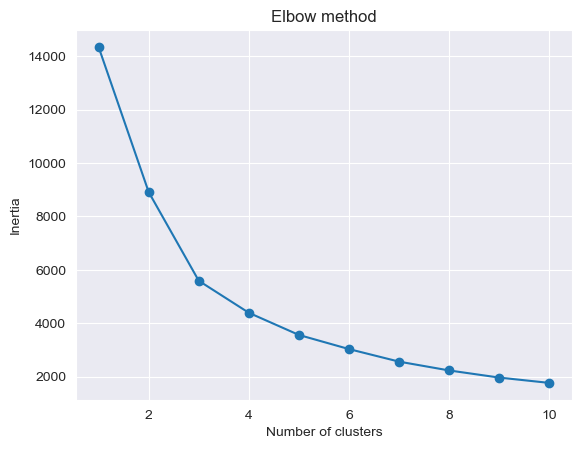

In [44]:
res = metodo_do_cotovelo_kmeans(df)

In [48]:
res

,pca1,pca2
0,0.514751,0.314781
1,-0.143992,0.476389
2,-0.193043,-0.658089
3,-0.066086,1.116383
4,0.064595,0.303363
...,...,...
9498,-0.199267,1.101776
9499,-0.361465,-0.071195
9500,2.044798,0.556369
9501,0.661522,-0.121791


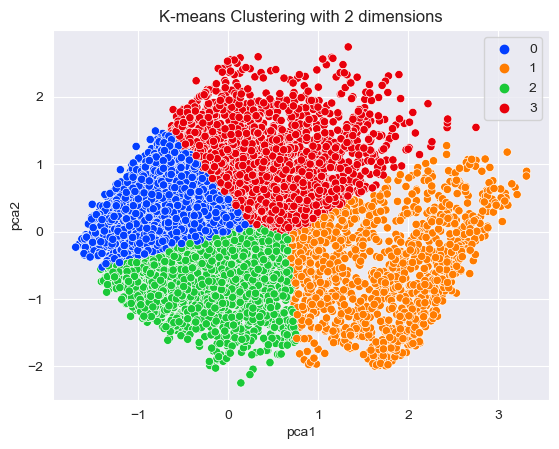

In [45]:
res_clusters_1 = kmeans_scatterplot(res,4)

In [47]:
res_clusters_1

array([3, 0, 2, ..., 1, 2, 0])

In [164]:
add_cluster_column_to_df(res,res_clusters_1,'kmeans (k=4)').to_excel('clusters.xlsx')

In [12]:
df_cluster = open_sheet('rem_features_transformado_10000_sample.xlsx')

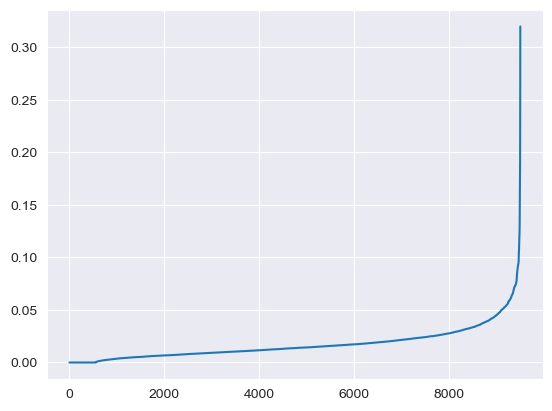

In [29]:
df_1 = plot_epsilon_graph(df_cluster,100)

In [14]:
df_1

,Estação do Ano_Inverno,Estação do Ano_Outono,Estação do Ano_Primavera,Estação do Ano_Verão,Hora_Hora de ponta fim de dia,Hora_Hora de ponta inicio de dia,Hora_Manhã,Hora_Noite,Hora_Tarde,Velocidade local_100.0 - 120.0,...,Natureza_Colisão,Natureza_Despiste,Traçado 1_Curva,Traçado 1_Recta,Traçado 2_Com inclinação,Traçado 2_Em Lomba,Traçado 2_Em patamar,Traçado 3_Berma não pavimentada,Traçado 3_Berma pavimentada,Traçado 3_Sem berma ou impraticável
0,1,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,1
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
2,1,0,0,0,0,0,0,1,0,0,...,1,0,0,1,1,0,0,0,0,1
3,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9498,0,1,0,0,0,0,0,1,0,0,...,1,0,1,0,1,0,0,0,0,1
9499,0,1,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,1,0,1,0
9500,0,1,0,0,0,0,0,0,1,0,...,0,1,1,0,1,0,0,0,1,0
9501,0,1,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0


Estimated number of clusters: 3
Estimated number of noise points: 1062


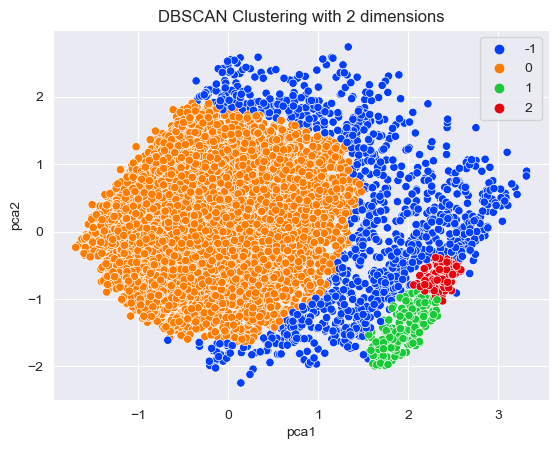

In [36]:
res = dbscan_clustering(df_1,50,0.20)
#Fazer pca (2 ou 3) antes do clustering. Tb podemos fazer visualizar depois apenas escolhendo duas features em vez de fazer PCA.

In [34]:
#Aprendizagem supervisionada

def typeOfInjury(df_injury):
    for x in range(len(df_injury)):
        mortos=df_injury.loc[x,'Num. Mortos a 30 dias']
        feridosgraves=df_injury.loc[x,'Num. Feridos graves a 30 dias']
        if mortos!=0 and feridosgraves!=0:
            string='non-light injuries'
        else:
            string='light injuries'
        df_injury.loc[x,'Tipo de Lesão']=string
    return df_injury

def get_1000_de_cada_file_apre_supervisionada(df_files):
    all_df=[]
    for df_year in reversed(df_files):
        print("Novo ano")
        total_lines = df_year.shape[0]
        all_df_year = []
        for j in range(1,13):
            df_month = df_year[df_year['Mês']==str(j)]
            perc_total_amostra = df_month.shape[0]/total_lines
            total_lines_month = int(perc_total_amostra*817)
            total_ligth_injuries = int(total_lines_month/2)
            df_month = typeOfInjury(df_month)
            df_light = df_month[df_month['Tipo de Lesão'] == "light injuries"]
            print("Light: "+str(df_light.shape[0]))
            df_non_light = df_month[df_month['Tipo de Lesão'] == "non-light injuries"]
            print("Non-Light: "+str(df_non_light.shape[0]))
            all_df_year.append(df_light.sample(n = total_ligth_injuries))
            all_df_year.append(df_non_light.sample(n = total_ligth_injuries))
        all_df.append(pd.concat(all_df_year))
    return pd.concat(all_df)

def get_sample_apre_supervisionada():
    df_files = []
    for i in range(10):
        name = "201"+str(i)+"Acidentes.xlsx"
        print("File: "+name)
        df_temp = open_sheet(name)
        df_files.append(alterar_coluna_dataHora(df_temp))
    return df_files



In [30]:
result_of_sample = get_sample_apre_supervisionada()

File: 2010Acidentes.xlsx
Alterou Type
File: 2011Acidentes.xlsx
Alterou Type
File: 2012Acidentes.xlsx
Alterou Type
File: 2013Acidentes.xlsx
Alterou Type
File: 2014Acidentes.xlsx
Alterou Type
File: 2015Acidentes.xlsx
Alterou Type
File: 2016Acidentes.xlsx
Alterou Type
File: 2017Acidentes.xlsx
Alterou Type
File: 2018Acidentes.xlsx
Alterou Type
File: 2019Acidentes.xlsx
Alterou Type


In [35]:
df_excel = get_1000_de_cada_file_apre_supervisionada(result_of_sample)
df_excel = df_excel.rename(columns = {'Datahora':'Ano'}, inplace = False)
df_excel.to_excel("10000_sample_aprendizagem_supervisionada.xlsx")

Novo ano


C:\Users\Diogo Cosme\AppData\Local\Temp\ipykernel_25256\3327921549.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_injury.loc[x,'Tipo de Lesão']=string


Light: 2732
Non-Light: 14


ValueError: Cannot take a larger sample than population when 'replace=False'